<a href="https://www.kaggle.com/samuelnordmann/titanic-binary-classification?scriptVersionId=87387891" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

link to the notebook: https://www.kaggle.com/samuelnordmann/titanic-binary-classification

In this notebook I present a studycase of binary classification on the Titanic dataset. The task consists in predicting what passenger survived in the Titanic crash.

This dataset is classical and well studied. Here I propose my own original solution achieving 78.0% accuracy on the test set, and thus ranks in the top 20% at time of submission.

Most of the work lies in the data engineering that I detail and try to explain as clearly as possible. Then, I train a XGB Classifier on 7 features selected by Mutual Information score.

In [1]:
import numpy as np 
import pandas as pd 
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Load, explore the data, and feature engineering

## Load

We first load the data and print the first rows.

In [2]:
#Load the dataset
data=pd.read_csv("../input/titanic/train.csv",index_col="PassengerId")
y=data["Survived"]
X=data.drop(labels=["Survived"], axis=1)

Let us take a glance at the input data

In [3]:
print('number of data inputs = ',len(X.index))
X.head()

number of data inputs =  891


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


and the first rows of the labels

In [4]:
y.head()

PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64

Here, 1 means that the passenger survived ; 0 means that the passenger died

Let us check the types and number of missing values

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 76.6+ KB


Let us explore and engineer each feature one by one

## Feature engineering

### Pclass

The feature Pclass only takes the values 1,2,3:

In [6]:
X.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

Since this feature represents the class category of the passenger's ticket, it is a categorical feature (even though the type is numerical). We decide to encode this feature as one-hot vectors.

In [7]:
oh= pd.get_dummies(X.Pclass,prefix="Pclass")
X = X.drop(labels='Pclass',axis=1).join(oh)

### Name

The only relevant information about name of the passenger should be whether the person has a title such as 'Mr.', or 'Mrs.', etc.

In [8]:
X['Title'] = X.Name.str.extract(' ([A-Za-z]+)\.', expand = False)
pd.crosstab(X.Title, X.Sex)

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


We decide to replace the rare titles by the string 'Rare', to gather the titles 'Mlle' and 'Ms', to gather the titles 'Mme' and 'Mrs'.

In [9]:
rare_titles = ['Capt', 'Col', 'Countess', 'Don', 'Dona', 'Dr', 'Jonkheer', 'Lady',
           'Major', 'Rev', 'Sir']

X.Title.replace(rare_titles, 'Rare', inplace = True)
X.Title.replace(['Mlle', 'Ms'], 'Miss', inplace = True)
X.Title.replace(['Mme'], 'Mrs', inplace = True)
pd.crosstab(X.Title, X.Sex)

Sex,female,male
Title,,
Master,0,40
Miss,185,0
Mr,0,517
Mrs,126,0
Rare,3,20


<AxesSubplot:xlabel='Title', ylabel='count'>

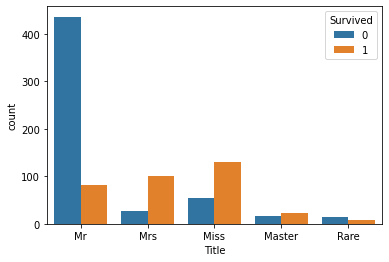

In [10]:
sns.countplot(x=X.Title,hue=data.Survived)

In [11]:
oh= pd.get_dummies(X.Title,prefix="Title")
X = X.drop(labels=['Name','Title'],axis=1).join(oh)
#X.Name = (X.Name.str.contains('Mr.')|X.Name.str.contains('Mrs.')).astype(np.uint8)

### Sex

The column 'Sex' takes only two values:

In [12]:
X.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

We encode male as 0 and female as 1:X.Sex= (X.Sex=='female')

In [13]:
X.Sex= (X.Sex=='female').astype(np.uint8)

<AxesSubplot:xlabel='Sex', ylabel='count'>

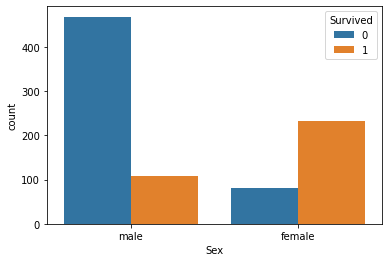

In [14]:
sns.countplot(data=data,x='Sex',hue="Survived")

### Age

<AxesSubplot:xlabel='Age', ylabel='Density'>

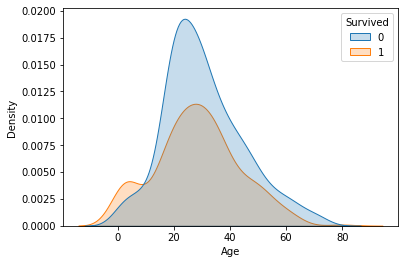

In [15]:
sns.kdeplot(X.Age,hue=y, shade=True)

Let us check the ratio of missing value for this feature.

In [16]:
ratio = np.round(X.Age.isna().sum()/len(X.index)*100, decimals=1)
print('The percentage of missing ages is ', ratio,'%')

The percentage of missing ages is  19.9 %


This ratio is quite high and so dropping the raws with missing values seems link a bad idea. We proceed to a simple mean imput, i.e., we replace the missing values by the average Age of the whole dataset.

In [17]:
X.Age[X.Age.isna()] = X.Age.mean()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Let us now look at the stastics of the feature

In [18]:
X.Age.describe()

count    891.000000
mean      29.699118
std       13.002015
min        0.420000
25%       22.000000
50%       29.699118
75%       35.000000
max       80.000000
Name: Age, dtype: float64

We decide to rescale the feature by substracting the mean and dividing by the standard deviation:

In [19]:
X.Age = (X.Age-X.Age.mean())/X.Age.std()

### SibSp

<AxesSubplot:xlabel='SibSp', ylabel='count'>

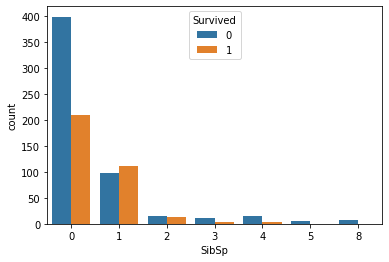

In [20]:
sns.countplot(data=data,x='SibSp',hue="Survived")

In [21]:
X.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

SibSp takes 7 different values, which is a slightly high for a one-hot encoding to be reasonable. Moreover, most of the dataset takes the values 0 and 1, while the values above 1 only represent a small percentage of the dataset:

In [22]:
ratio = np.round((X.SibSp>1).sum()/len(X.index)*100,decimals=1)
print("Percentage of the dataset whose SibSp is strictly above one = ",ratio,"%")

Percentage of the dataset whose SibSp is strictly above one =  8.3 %


Since SibSp seems like an ordinal feature, we decide to gather in one categorie all the values strictly above 1 and to give them the value 2. 

In [23]:
X.SibSp.clip(upper=2,inplace=True)

We then proceed to a one-hot encoding:

In [24]:
oh= pd.get_dummies(X.SibSp,prefix="SibSp")
X = X.drop(labels='SibSp',axis=1).join(oh)

### Parch

<AxesSubplot:xlabel='Parch', ylabel='count'>

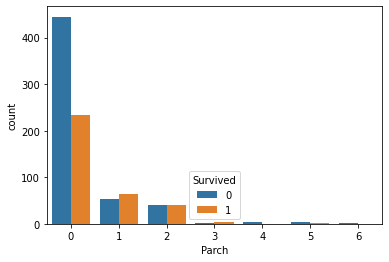

In [25]:
sns.countplot(data=data,x='Parch',hue="Survived")

In [26]:
X.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

We treat the Parch feature similarily to SibSp, by clipiing the value to 2 and then do a one-hot encoding.

In [27]:
X.Parch.clip(upper=2,inplace=True)
oh= pd.get_dummies(X.Parch,prefix="Parch")
X = X.drop(labels='Parch',axis=1).join(oh)

### Ticket

We simply drop this feature:

In [28]:
X.drop(labels='Ticket',axis=1,inplace=True)

### Fare

<AxesSubplot:xlabel='Fare', ylabel='Density'>

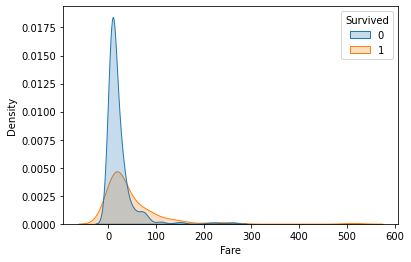

In [29]:
sns.kdeplot(data=data,x='Fare', shade=True,hue="Survived")

In [30]:
X.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

We decide to rescale the feature by substracting the mean and dividing by the standard deviation:

In [31]:
X.Fare = (X.Fare-X.Fare.mean())/X.Fare.std()

### Cabin

Here we have to tackle two issues: missing value and extracting valuable information from the Cabin number.

First, let us replace the missing value by the token 'U'

In [32]:
X.Cabin[X.Cabin.isna()]='U'

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Then, it seems reasonable to only keep the prefix letter of the cabin number (which could contain information on the category or location of the cabin).

In [33]:
X.Cabin=X.Cabin.str[0] #select the first letter
X.Cabin.value_counts() #print the statistics

U    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

<AxesSubplot:xlabel='Cabin', ylabel='count'>

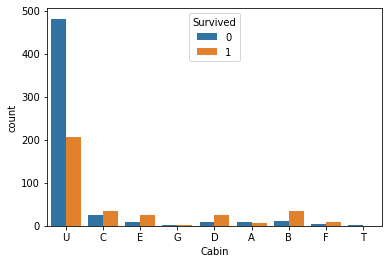

In [34]:
sns.countplot(data=data,x=X.Cabin,hue="Survived")

Let us perform a Chi2 test for independence for each value of Cabin taken separately.

In [35]:
from scipy.stats import chi2_contingency
for letter in X.Cabin.unique():
    cab_binary = X.Cabin==letter
    contigency = pd.crosstab(cab_binary, y) 
    c, p, dof, expected = chi2_contingency(contigency)
    p = np.round(p*100,decimals=3)
    print('Chi2 test for the independence of Cabin = ',letter,'. p-value =',p,"%")
    

Chi2 test for the independence of Cabin =  U . p-value = 0.0 %
Chi2 test for the independence of Cabin =  C . p-value = 0.102 %
Chi2 test for the independence of Cabin =  E . p-value = 0.003 %
Chi2 test for the independence of Cabin =  G . p-value = 100.0 %
Chi2 test for the independence of Cabin =  D . p-value = 0.002 %
Chi2 test for the independence of Cabin =  A . p-value = 69.098 %
Chi2 test for the independence of Cabin =  B . p-value = 0.0 %
Chi2 test for the independence of Cabin =  F . p-value = 14.928 %
Chi2 test for the independence of Cabin =  T . p-value = 100.0 %


We see from the statistics and the plots that most of the valuable information on the cabin letter is whether this letter is "U" (corresponding to missing data).

Let us one-encode this feature while discarding the categories G, A, F, T which have a poor p-value.

In [36]:
oh = pd.get_dummies(X.Cabin,prefix="Cabin")
categories_to_drop = ['Cabin_'+i for i in ['G','A','F','T']]
oh = oh.drop(labels = categories_to_drop, axis = 1) 

X = X.drop(labels='Cabin',axis=1).join(oh)

### Embarked

<AxesSubplot:xlabel='Embarked', ylabel='count'>

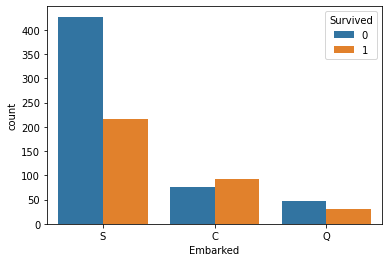

In [37]:
sns.countplot(data=data,x='Embarked',hue="Survived")

In [38]:
X.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

We proceed to a one-hot encoding

In [39]:
oh= pd.get_dummies(X.Embarked,prefix="Embarked")
X = X.drop(labels='Embarked',axis=1).join(oh)

## Conclusion of feature engineering 

In [40]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sex           891 non-null    uint8  
 1   Age           891 non-null    float64
 2   Fare          891 non-null    float64
 3   Pclass_1      891 non-null    uint8  
 4   Pclass_2      891 non-null    uint8  
 5   Pclass_3      891 non-null    uint8  
 6   Title_Master  891 non-null    uint8  
 7   Title_Miss    891 non-null    uint8  
 8   Title_Mr      891 non-null    uint8  
 9   Title_Mrs     891 non-null    uint8  
 10  Title_Rare    891 non-null    uint8  
 11  SibSp_0       891 non-null    uint8  
 12  SibSp_1       891 non-null    uint8  
 13  SibSp_2       891 non-null    uint8  
 14  Parch_0       891 non-null    uint8  
 15  Parch_1       891 non-null    uint8  
 16  Parch_2       891 non-null    uint8  
 17  Cabin_B       891 non-null    uint8  
 18  Cabin_C       891 non-null    

In [41]:
X.corr()

,Sex,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,...,Parch_1,Parch_2,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_U,Embarked_C,Embarked_Q,Embarked_S
Sex,1.000000,-0.084153,0.182333,0.098013,0.064746,-0.137143,-0.159934,0.693916,-0.867334,0.550146,...,0.127636,0.201880,0.109689,0.058649,0.079248,0.047003,-0.140391,0.082853,0.074115,-0.125722
Age,-0.084153,1.000000,0.091566,0.319916,0.006589,-0.281004,-0.377265,-0.249169,0.185900,0.164533,...,-0.147908,-0.199046,0.091394,0.113149,0.132319,0.117211,-0.233123,0.032024,-0.013855,-0.027121
Fare,0.182333,0.091566,1.000000,0.591711,-0.118557,-0.413333,0.010908,0.119518,-0.183766,0.107259,...,0.114650,0.202590,0.386297,0.364318,0.098878,0.053717,-0.482075,0.269335,-0.117216,-0.166603
Pclass_1,0.098013,0.319916,0.591711,1.000000,-0.288585,-0.626738,-0.084700,0.020348,-0.097288,0.093608,...,0.018496,-0.008743,0.417160,0.470749,0.291218,0.242675,-0.788773,0.296423,-0.155342,-0.170379
Pclass_2,0.064746,0.006589,-0.118557,-0.288585,1.000000,-0.565210,0.009903,-0.021903,-0.088569,0.119193,...,0.062425,-0.014539,-0.120386,-0.135851,-0.041325,-0.038864,0.172413,-0.125416,-0.127301,0.192061
Pclass_3,-0.137143,-0.281004,-0.413333,-0.626738,-0.565210,1.000000,0.064918,0.000293,0.155907,-0.177658,...,-0.066741,0.019365,-0.261450,-0.295036,-0.217282,-0.177461,0.539291,-0.153329,0.237449,-0.009511
Title_Master,-0.159934,-0.377265,0.010908,-0.084700,0.009903,0.064918,1.000000,-0.110981,-0.254903,-0.087987,...,0.283067,0.206088,-0.026914,-0.035937,-0.042519,-0.012717,0.027841,-0.035225,0.010478,0.025291
Title_Miss,0.693916,-0.249169,0.119518,0.020348,-0.021903,0.000293,-0.110981,1.000000,-0.601857,-0.207749,...,0.028567,0.145912,0.064880,0.008343,0.016822,0.020161,-0.043749,0.036204,0.167531,-0.140414
Title_Mr,-0.867334,0.185900,-0.183766,-0.097288,-0.088569,0.155907,-0.254903,-0.601857,1.000000,-0.477160,...,-0.237967,-0.266175,-0.114673,-0.047873,-0.049952,-0.031384,0.137319,-0.072567,-0.078338,0.118482
Title_Mrs,0.550146,0.164533,0.107259,0.093608,0.119193,-0.177658,-0.087987,-0.207749,-0.477160,1.000000,...,0.145511,0.110266,0.062731,0.073270,0.073907,0.042837,-0.123817,0.067872,-0.090432,-0.007704


## Feature scoring

We rank the features using the Mutal Information Score.

<AxesSubplot:xlabel='MI Scores'>

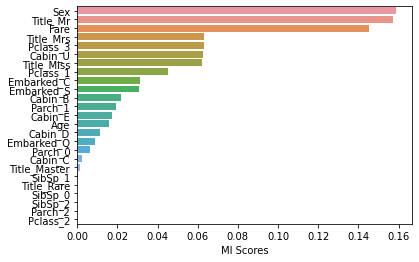

In [42]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    X = X.copy()
    discrete_features = [X.columns.get_loc(column_name) for column_name in X.dtypes[X.dtypes=='uint8'].index] 
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

    
  
mi_scores = make_mi_scores(X, y)
X = X[mi_scores.index]  
sns.barplot(x=mi_scores, y=mi_scores.index)


We also perform a simple logistic regression an plot the results

intercept =  -0.050002245156085236


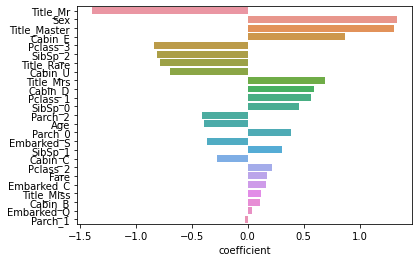

In [43]:
from sklearn.linear_model import LogisticRegression

model_LogReg = LogisticRegression(solver='liblinear')
model_LogReg.fit(X, y)

coefs=pd.DataFrame({'coefficient':model_LogReg.coef_[0]}, index = X.columns)

coefs.sort_values('coefficient', key=abs, ascending=False,inplace=True)


sns.barplot(y=coefs.index, x=coefs['coefficient'])

print('intercept = ',model_LogReg.intercept_[0])


## Splitting

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val= train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=1,shuffle=True)

# Models

In [45]:
from sklearn.metrics import accuracy_score
import random

## XGB Classifier

### Hyperparameter search

In [46]:
scores_XGB=pd.DataFrame(columns = ['k','n_estimators','max_depth','score'])

In [47]:
from xgboost import XGBClassifier

if True: #To conveniently choose to not execute this cell at test time
    for _ in range(70): #We iterate to search best hyperparameters

        #Hyperparameters
        k= random.randint(6, 10) #number of selected features
        n_estimators = random.randint(50, 300) #Number of boosting rounds
        max_depth = random.randint(5, 7) #Maximum tree depth for base learners.

        model_XGBClassifier = XGBClassifier(n_estimators=n_estimators,max_depth=max_depth,use_label_encoder=False,eval_metric="error",random_state=0)

        selected_features = mi_scores.index[:k] #Selected features
        model_XGBClassifier.fit(X_train[selected_features], y_train, 
                            eval_set=[(X_val[selected_features],y_val)],
                           eval_metric='error',
                           verbose=False)

        preds = model_XGBClassifier.predict(X_val[selected_features])
        score = accuracy_score(y_val,preds)
        max_depth = model_XGBClassifier.get_params()['max_depth']
        score = pd.Series({'k':k,'n_estimators':n_estimators,'max_depth':max_depth,'score':score})
        scores_XGB = scores_XGB.append(score,ignore_index=True)

    scores_XGB = scores_XGB.sort_values(["score"],ascending=False)
    scores_XGB



In [48]:
misclassified=X_val.loc[y_val[y_val!=preds].index]
misclassified.describe()

,Sex,Title_Mr,Fare,Title_Mrs,Pclass_3,Cabin_U,Title_Miss,Pclass_1,Embarked_C,Embarked_S,...,Embarked_Q,Parch_0,Cabin_C,Title_Master,SibSp_1,Title_Rare,SibSp_0,SibSp_2,Parch_2,Pclass_2
count,35.000000,35.00000,35.000000,35.000000,35.00000,35.000000,35.00000,35.000000,35.000000,35.000000,...,35.000000,35.00000,35.000000,35.0,35.00000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.342857,0.60000,0.244661,0.142857,0.60000,0.685714,0.20000,0.314286,0.257143,0.714286,...,0.028571,0.80000,0.085714,0.0,0.20000,0.057143,0.771429,0.028571,0.114286,0.085714
std,0.481594,0.49705,1.760628,0.355036,0.49705,0.471008,0.40584,0.471008,0.443440,0.458349,...,0.169031,0.40584,0.284029,0.0,0.40584,0.235504,0.426043,0.169031,0.322803,0.284029
min,0.000000,0.00000,-0.496126,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,-0.473530,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,1.00000,0.000000,0.0,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,1.00000,-0.331281,0.000000,1.00000,1.000000,0.00000,0.000000,0.000000,1.000000,...,0.000000,1.00000,0.000000,0.0,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,1.00000,0.284661,0.000000,1.00000,1.000000,0.00000,1.000000,0.500000,1.000000,...,0.000000,1.00000,0.000000,0.0,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.00000,9.661740,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,0.0,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:xlabel='k', ylabel='score'>

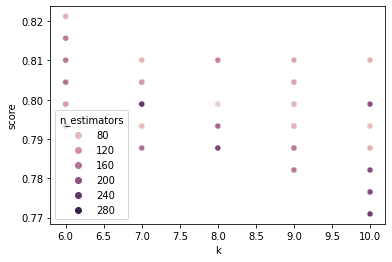

In [49]:
sns.scatterplot(x=scores_XGB.k,y=scores_XGB.score,hue=scores_XGB.n_estimators)

k=7 seems like a good choice.

<AxesSubplot:xlabel='max_depth', ylabel='score'>

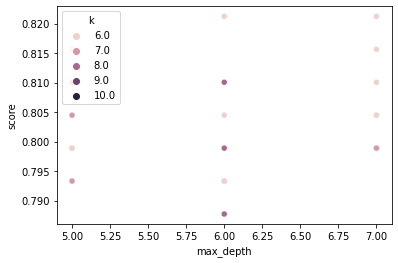

In [50]:
scores_XGB_k7= scores_XGB[scores_XGB.k.isin([5,6,7,8])]

sns.scatterplot(x=scores_XGB_k7.max_depth,y=scores_XGB_k7.score,hue=scores_XGB.k)

max_depth = 5 is a good choice

<AxesSubplot:xlabel='n_estimators', ylabel='score'>

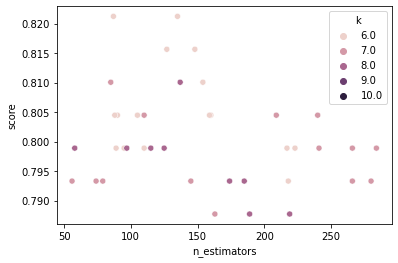

In [51]:
scores_XGB_k7= scores_XGB[scores_XGB.k.isin([6,7,8])]

sns.scatterplot(x=scores_XGB_k7.n_estimators,y=scores_XGB_k7.score,hue=scores_XGB.k)

n_estimators = 200 seems like a good choice

# Test

## Preprocessing of the test set

In [52]:
X_test=pd.read_csv("../input/titanic/test.csv",index_col="PassengerId")
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


In [53]:
#Pclass
oh= pd.get_dummies(X_test.Pclass,prefix="Pclass")
X_test = X_test.drop(labels='Pclass',axis=1).join(oh)

#Name
X_test['Title'] = X_test.Name.str.extract(' ([A-Za-z]+)\.', expand = False)
X_test.Title.replace(rare_titles, 'Rare', inplace = True)
X_test.Title.replace(['Mlle', 'Ms'], 'Miss', inplace = True)
X_test.Title.replace(['Mme'], 'Mrs', inplace = True)

oh= pd.get_dummies(X_test.Title,prefix="Title")
X_test = X_test.drop(labels=['Name','Title'],axis=1).join(oh)

#Sex
X_test.Sex= (X_test.Sex=='female').astype(np.uint8)

#Age
X_test.Age[X_test.Age.isna()] = X.Age.mean()
X_test.Age = (X_test.Age-X.Age.mean())/X.Age.std()

#SibSp
X_test.SibSp.clip(upper=2,inplace=True)
oh= pd.get_dummies(X_test.SibSp,prefix="SibSp")
X_test = X_test.drop(labels='SibSp',axis=1).join(oh)

#Parch
X_test.Parch.clip(upper=2,inplace=True)
oh= pd.get_dummies(X_test.Parch,prefix="Parch")
X_test = X_test.drop(labels='Parch',axis=1).join(oh)

#Ticket
X_test.drop(labels='Ticket',axis=1,inplace=True)

#Fare
X_test.Fare[X_test.Fare.isna()] = X.Fare.mean()
X_test.Fare = (X_test.Fare-X.Fare.mean())/X.Fare.std()


#Cabin
X_test.Cabin[X_test.Cabin.isna()]='U'
X_test.Cabin=X_test.Cabin.str[0] #select the first letter
oh = pd.get_dummies(X_test.Cabin,prefix="Cabin")
categories_to_drop = ['Cabin_'+i for i in ['G','A','F','T']]
for category in categories_to_drop:
    try:
        oh = oh.drop(labels = category, axis = 1)
    except:
        pass
       
X_test = X_test.drop(labels='Cabin',axis=1).join(oh)


#Embarked
oh= pd.get_dummies(X_test.Embarked,prefix="Embarked")
X_test = X_test.drop(labels='Embarked',axis=1).join(oh)

X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sex           418 non-null    uint8  
 1   Age           418 non-null    float64
 2   Fare          418 non-null    float64
 3   Pclass_1      418 non-null    uint8  
 4   Pclass_2      418 non-null    uint8  
 5   Pclass_3      418 non-null    uint8  
 6   Title_Master  418 non-null    uint8  
 7   Title_Miss    418 non-null    uint8  
 8   Title_Mr      418 non-null    uint8  
 9   Title_Mrs     418 non-null    uint8  
 10  Title_Rare    418 non-null    uint8  
 11  SibSp_0       418 non-null    uint8  
 12  SibSp_1       418 non-null    uint8  
 13  SibSp_2       418 non-null    uint8  
 14  Parch_0       418 non-null    uint8  
 15  Parch_1       418 non-null    uint8  
 16  Parch_2       418 non-null    uint8  
 17  Cabin_B       418 non-null    uint8  
 18  Cabin_C       418 non-null 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Final XGBClassifier model

In [54]:
k= 7 #number of selected features
n_estimators = 200 #Number of boosting rounds
max_depth = 5 #Maximum tree depth for base learners.

model_XGBClassifier = XGBClassifier(n_estimators=n_estimators,
                                    max_depth=max_depth,
                                    use_label_encoder=False,
                                    eval_metric="error",
                                    random_state=0)

selected_features = mi_scores.index[:k] #Selected features
model_XGBClassifier.fit(X[selected_features], y, 
                   eval_metric='error',
                   verbose=False)

preds = model_XGBClassifier.predict(X_test[selected_features])


In [55]:
submission = pd.DataFrame({'Survived':preds}, index=X_test.index)
submission.to_csv("submission.csv")